<h1><center>Time Series Analysis with Avocado Prices</center></h1>

### The data for this analysis comes from [Avocado Prices](https://www.kaggle.com/neuromusic/avocado-prices) dataset from Kaggle.  The data includes the following:

    1. Date - Weekly Dates on Sundays from 2015-2018
    2. Average Price - Average Price of a single avocado
    3. Total Volume - Total # of Avocados Sold
    4. 4046/4225/4770 - Total Volume of avocados sold by PLU
    5. Total Bags - Total bags sold
    6. Small/Large/XLarge Bags - Total Bags sold by type
    7. Type - Organic or Conventional
    8. Year - Year of observation
    9. Region - City or Region of the observation
    
This data was originally obtained from [Hass Avocado Board](http://www.hassavocadoboard.com/retail/volume-and-price-data) which has data going back to 2004 if anybody wishes to go back further in time.

In [22]:
import pandas as pd
import numpy as np

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")

import warnings

In [2]:
df = pd.read_csv('./data/avocado.csv', index_col=0)

In [3]:
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df.set_index('Date', inplace=True)

In [6]:
df.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,
2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


Since we have two different types of avocados (organic and conventional) and multiple regions, it's easier to visualize the data by picking a specific region and type of avocado.  Otherwise you get lots of noise in your visualizations and certainly in the model.  It's easier to model by the Total United States, specific regions (Northeast, Southeast, etc), or even cities.

Here we restrict the data to Total United States and conventional avocados.  You can certainly try all different sorts of combinations as you see fit.

In [7]:
conventional = df[(df.region == 'TotalUS')&(df.type == 'conventional')]

In [8]:
conventional.head()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
Date,,,,,,,,,,,,
2015-12-27,0.95,27297983.67,9626901.09,10197890.05,1184340.09,6288852.44,4850404.09,1252626.31,185822.04,conventional,2015,TotalUS
2015-12-20,0.98,25083647.17,8710021.76,9329861.85,1201020.01,5842743.55,4618389.66,1025048.77,199305.12,conventional,2015,TotalUS
2015-12-13,0.93,28041335.38,9855053.66,10805838.91,1016163.17,6364279.64,4964462.13,1371440.28,28377.23,conventional,2015,TotalUS
2015-12-06,0.89,28800396.57,9405464.36,12160838.62,931830.63,6302262.96,5005077.36,1233956.21,63229.39,conventional,2015,TotalUS
2015-11-29,0.99,22617999.38,8094803.56,9003178.41,731008.41,4789009.00,3901953.04,856560.34,30495.62,conventional,2015,TotalUS


As you can see from the plot below, avocado prices throughout the United States did not show much seasonality in 2015, but that certainly changed in 2016 and 2017.  This provides some insight on how our model will forecast prices in the future since I believe the model is essentially "weighed" down by the relative flatness of prices in 2015.

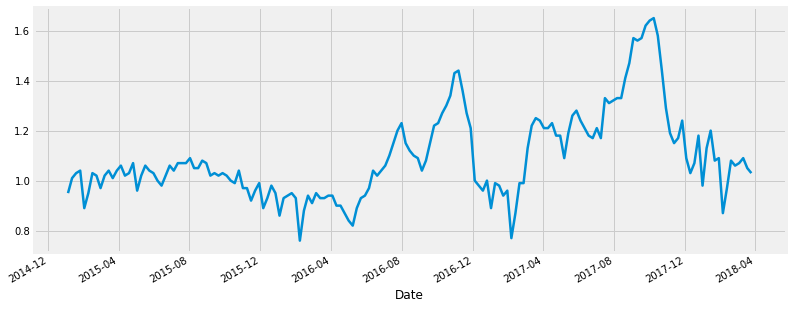

In [9]:
conventional['AveragePrice'].plot(lw=2.5, figsize=(12,5));

I later noticed that the dataset was not actually sorted by Date.  Since we earlier set the Date as our index, I needed to sort the index to make sure that the model runs correctly from oldest to newest date.  One of those things you realize when you start modeling.

In [10]:
conventional = conventional.sort_index()

Dropping all the columns we don't necessarily care about any more...

In [11]:
conventional = conventional.drop(columns = ['Total Volume', '4046', '4225', '4770', 'Total Bags',
       'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year', 'region'])

In [12]:
conventional.head()

,AveragePrice
Date,
2015-01-04,0.95
2015-01-11,1.01
2015-01-18,1.03
2015-01-25,1.04
2015-02-01,0.89


The following piece of code was taken from [How to Make Out-of-Sample Forecasts with ARIMA in Python](https://machinelearningmastery.com/make-sample-forecasts-arima-python/).

When you're doing an ARIMA model, you pass in an "order" that is your p, d, and q values.  There are lots of information on what those actually stand for, but this code has two functions.  

The first function (evaluate_arima_model) takes in your dataset and specific order.  It then splits your original data into a train size comprised of the first 66% of your data, and a test size with last portion or 34% of your data.  It then runs an ARIMA model with the the training data with the order given, and forecasts based on your fitted model.  This then gets compared to your test data to to find the error in your model as defined by the Mean Squared Error (MSE).

The second function (evaluate_models) basically runs through every model combination based on the data set, the p-values, d-values, and q-values you input.  While doing so, it collects each MSE from the first function and prints out the very best/lowest MSE score based on the p, d, and q values.

In [13]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 4)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(conventional.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.060
ARIMA(0, 0, 1) MSE=0.022
ARIMA(0, 1, 0) MSE=0.007
ARIMA(0, 1, 1) MSE=0.007
ARIMA(0, 1, 2) MSE=0.007
ARIMA(0, 1, 3) MSE=0.007
ARIMA(0, 2, 0) MSE=0.013
ARIMA(0, 2, 1) MSE=0.007
ARIMA(1, 0, 0) MSE=0.007
ARIMA(1, 0, 1) MSE=0.007
ARIMA(1, 0, 2) MSE=0.007
ARIMA(1, 0, 3) MSE=0.007
ARIMA(1, 1, 0) MSE=0.007
ARIMA(1, 2, 0) MSE=0.010
ARIMA(1, 2, 1) MSE=0.007
ARIMA(2, 0, 0) MSE=0.007
ARIMA(2, 0, 1) MSE=0.007
ARIMA(2, 0, 2) MSE=0.007
ARIMA(2, 0, 3) MSE=0.007
ARIMA(2, 1, 0) MSE=0.007
ARIMA(2, 2, 0) MSE=0.009
ARIMA(3, 0, 0) MSE=0.007
ARIMA(3, 0, 1) MSE=0.007
ARIMA(3, 0, 2) MSE=0.007
ARIMA(3, 0, 3) MSE=0.007
ARIMA(3, 1, 0) MSE=0.007
ARIMA(3, 1, 1) MSE=0.007
ARIMA(3, 2, 0) MSE=0.009
Best ARIMA(1, 0, 0) MSE=0.007


The very best ARIMA model has an order of (1, 0, 0) which we can now pass into our ARIMA model with the entire dataset to predict future avocado prices.

The following cell fits the ARIMA model, runs the predictions, then puts them in a nice DataFrame for us to compare
visually first.

In [14]:
model = ARIMA(conventional['AveragePrice'], order = (1, 0, 0))
results_ARIMA = model.fit()
predictions = round(results_ARIMA.predict(), 2)
preds = pd.DataFrame(list(zip(list(predictions.index),list(predictions))),columns=['Date',
                                                                                   'PredictedPrice']).set_index('Date')
predicted_df = pd.merge(conventional[1:], preds, left_index=True, right_index=True)
predicted_df.head()

,AveragePrice,PredictedPrice
Date,,
2015-01-11,1.01,0.96
2015-01-18,1.03,1.02
2015-01-25,1.04,1.03
2015-02-01,0.89,1.04
2015-02-08,0.95,0.90


Now we score the model based on the true values we have and the predictions we just made.  As can be see, we're pretty darn close to zero...

In [15]:
print("\tMean Squared Error:", mean_squared_error(predicted_df['AveragePrice'], predicted_df['PredictedPrice']))
print("\tRoot Mean Squared Error:", np.sqrt(mean_squared_error(predicted_df['AveragePrice'], 
                                                               predicted_df['PredictedPrice'])))

	Mean Squared Error: 0.004301785714285715
	Root Mean Squared Error: 0.06558799977347773


...but then when you use ARIMA's .plot_predict, we notice that the forecast is actually not very good at all. It's completely flat and doesn't account for any kind of seasonality that we saw in 2016 and 2017.  The confidence interval is also extremely large and doesn't really show us anything of value in this case.  Of course, that's because we didn't test for stationarity or do any kind of calculations (log, moving average, exponential weighted moving average, etc.)

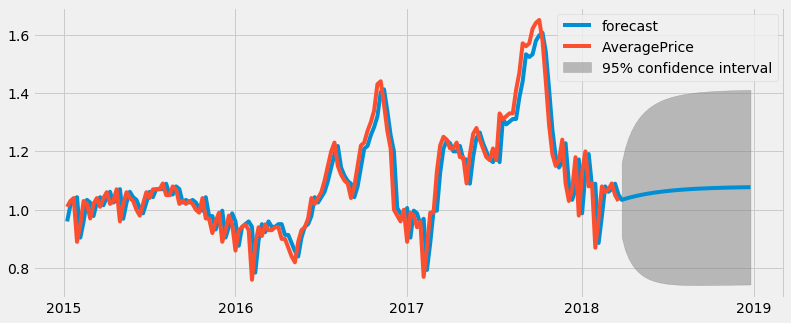

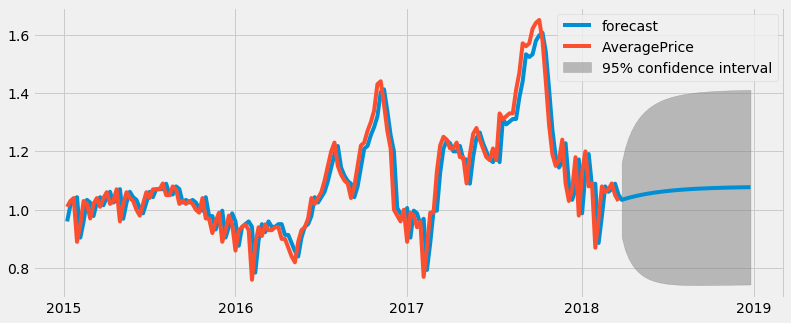

In [23]:
results_ARIMA.plot_predict(start='2015-01-11', end = '2018-12-30')

SARIMAX to the rescue!  SARIMAX is another time series modeling type that does take into account seasonality.  We go ahead and enter the same order as we did for the ARIMA model, (1, 0, 0), enter in the seasonal order which I personally interpreted as the normal order plus the frequency of your dates...which in this case is 52 for the 52 weeks in the year.

In [17]:
mod = sm.tsa.statespace.SARIMAX(conventional['AveragePrice'],
                                order=(1, 0, 0),
                                seasonal_order=(1, 0, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

SARIMAX_results = mod.fit()

SARIMAX_predictions = SARIMAX_results.predict()

SARIMAX_preds = pd.DataFrame(list(zip(list(SARIMAX_predictions.index),list(SARIMAX_predictions))),
                             columns=['Date','PredictedPrice']).set_index('Date')

SARIMAX_predicted_df = pd.merge(conventional[1:], SARIMAX_preds, left_index=True, right_index=True)
SARIMAX_predicted_df.head()

,AveragePrice,PredictedPrice
Date,,
2015-01-11,1.01,0.943352
2015-01-18,1.03,1.002932
2015-01-25,1.04,1.022792
2015-02-01,0.89,1.032722
2015-02-08,0.95,0.883771


Once again, we calculate that are MSE and RMSE are essentially zero.

In [18]:
print("\tMean Squared Error:", mean_squared_error(SARIMAX_predicted_df['AveragePrice'], 
                                                  SARIMAX_predicted_df['PredictedPrice']))
print("\tRoot Mean Squared Error:", np.sqrt(mean_squared_error(SARIMAX_predicted_df['AveragePrice'], 
                                                               SARIMAX_predicted_df['PredictedPrice'])))

	Mean Squared Error: 0.006042329078270532
	Root Mean Squared Error: 0.07773241973765214


As we did above with the ARIMA model, we now forecast out from April 1st, 2018 through the end of 2018...

In [19]:
SARIMAX_forecast = pd.DataFrame(SARIMAX_results.forecast(steps = 40), columns = ['Forecasted Price'])

...and then plot it. As you can see the model predicts a bit of a spike in 2015 because of the seasonal trends we saw in 2016 and 2017.  However, we can now see a more favorable forecast of rising and falling prices that we also saw in 2016 and 2017.  However, my own personal interpretation of the "smaller" rise in prices is due to the relative flatness of prices in 2015.  If 2015 had the same trends as 2016 and 2017, the forecast for 2018 would also have shown a larger price increase for October and November.

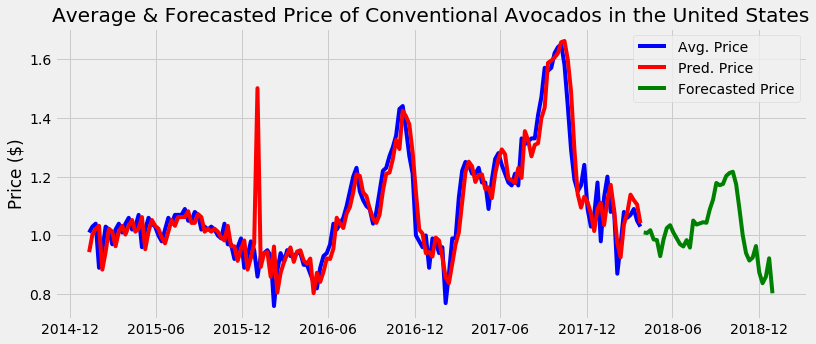

In [24]:
fig=plt.figure()
fig.show()
ax=fig.add_subplot(111)

ax.plot(SARIMAX_predicted_df['AveragePrice'],c='b',label='Avg. Price')
ax.plot(SARIMAX_predicted_df['PredictedPrice'],c='r', label='Pred. Price')
ax.plot(SARIMAX_forecast['Forecasted Price'],c='g', label='Forecasted Price')

plt.legend(loc='best')
plt.ylabel('Price ($)')
plt.title('Average & Forecasted Price of Conventional Avocados in the United States')
plt.draw()

Obviously I realize that this is a very simplistic approach to this particular problem.  We didn't do all the normal stationarity checks that one would do with time series analysis as well as plotting autocorrelation and partial autocorrelation graphs. There is so much more you can do with this dataset.  However, my goal here was simply to take the data given and find a quick and dirty model that intuitively made some sense.  The SARIMAX model helped me do that.

I would encourage anybody reading this to try different variations on this data:

1. Organic vs. conventional - Create a classification model and determine if you can predict if an avocado is organic or conventional given all the other variables?
2. Region - Predict region with classification model?
3. Try out the different regions and map out the various differences in price or forecasts in each one.
4. As of this posting, the Hass Avocado Board has prices through 7/15/2018.  One could either append the data from 4/1/2018 to further their forecast, or do a .fit with the original dataset through 3/25/2018, and run a .forecast through 7/15/2018 then do their error calculations based on that information now that we have it.

There is much that can be done with this particular dataset.  Good luck!